# Data Understanding — datadelevry.xlsx

Ce notebook exécute **l'étape Data Understanding** du projet CRISP-DM pour les 3 BOs :
- BO1 (Supervisé) : prédiction du temps de livraison (delivery_duration_min).
- BO2 (Non supervisé) : segmentation des commandes.
- BO3 (Réduction de dimension) : simplifier les variables numériques.

**Instructions** : place `datadelevry.xlsx` dans le même dossier que ce notebook ou modifie le chemin `FILE_PATH` dans la cellule 1.


In [1]:

# 1) Setup - imports et chemin du fichier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display

# Chemin du fichier Excel - modifie si nécessaire
FILE_PATH = 'datadelevry.xlsx'
print('FILE_PATH =', FILE_PATH)
print('Working dir:', os.getcwd())


FILE_PATH = datadelevry.xlsx
Working dir: c:\Users\chams\OneDrive\Bureau\machine learning


In [2]:

# 2) Lecture du fichier Excel
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"Fichier non trouvé: {FILE_PATH}")

# Lire sans header pour gérer le cas "tout dans une seule colonne"
df_raw = pd.read_excel(FILE_PATH, header=None)
print('Raw shape:', df_raw.shape)

if df_raw.shape[1] == 1:
    print('Fichier avec une seule colonne détecté -> split par virgule')
    df = df_raw[0].astype(str).str.split(',', expand=True)
    # Détecter si la première ligne contient les noms de colonnes
    first_row = df.iloc[0].astype(str).str.lower().tolist()
    if any('created' in s or 'actual' in s or 'store' in s for s in first_row):
        df.columns = df.iloc[0]
        df = df[1:].reset_index(drop=True)
        print('En-tête détectée et appliquée. Nouvelle forme :', df.shape)
    else:
        df.columns = [f'col_{i}' for i in range(df.shape[1])]
        print('Aucun en-tête détecté ; colonnes génériques appliquées. Nouvelle forme :', df.shape)
else:
    df = df_raw.copy()
    # S'assurer que les noms de colonnes sont des strings propres
    df.columns = [str(c).strip() for c in df.columns]
    print('Fichier multi-colonnes chargé. Shape:', df.shape)

display(df.head(8))


Raw shape: (172942, 1)
Fichier avec une seule colonne détecté -> split par virgule
En-tête détectée et appliquée. Nouvelle forme : (172941, 14)


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4.0,3441.0,4.0,557.0,1239.0,,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,,1.0,3.0,3900.0,3.0,,1600.0,6.0,6.0,9.0
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,f0ade77b43923b38237db569b016ba25,,1.0,3.0,5000.0,3.0,1500.0,1900.0,2.0,2.0,2.0
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,f0ade77b43923b38237db569b016ba25,,1.0,2.0,3900.0,2.0,1200.0,2700.0,10.0,9.0,9.0
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,f0ade77b43923b38237db569b016ba25,,1.0,4.0,4850.0,4.0,750.0,1800.0,7.0,8.0,7.0


In [3]:

# 3) Nettoyage des noms et renommage canonique
# Nettoyage espaces dans les noms de colonnes
df.columns = [str(c).strip() for c in df.columns]

# Tentative de renommage pour correspondre aux variables attendues
rename_map = {}
for c in df.columns:
    low = str(c).lower().replace(' ', '_')
    if 'market' in low and 'market_id' not in df.columns:
        rename_map[c] = 'market_id'
    if 'created' in low and 'created_at' not in df.columns:
        rename_map[c] = 'created_at'
    if 'actual' in low and 'delivery' in low and 'actual_delivery_time' not in df.columns:
        rename_map[c] = 'actual_delivery_time'
    if 'store_primary' in low and 'store_primary_category' not in df.columns:
        rename_map[c] = 'store_primary_category'
    if 'order_protocol' in low and 'order_protocol' not in df.columns:
        rename_map[c] = 'order_protocol'
    if 'total_items' in low and 'total_items' not in df.columns:
        rename_map[c] = 'total_items'
    if 'subtotal' in low and 'subtotal' not in df.columns:
        rename_map[c] = 'subtotal'
    if 'num_distinct' in low and 'num_distinct_items' not in df.columns:
        rename_map[c] = 'num_distinct_items'
    if 'min_item_price' in low and 'min_item_price' not in df.columns:
        rename_map[c] = 'min_item_price'
    if 'max_item_price' in low and 'max_item_price' not in df.columns:
        rename_map[c] = 'max_item_price'
    if 'onshift' in low and 'total_onshift_partners' not in df.columns:
        rename_map[c] = 'total_onshift_partners'
    if 'busy' in low and 'total_busy_partners' not in df.columns:
        rename_map[c] = 'total_busy_partners'
    if 'outstand' in low and 'total_outstanding_orders' not in df.columns:
        rename_map[c] = 'total_outstanding_orders'

# Appliquer renommage là où sûr
for k,v in rename_map.items():
    if v not in df.columns:
        df = df.rename(columns={k:v})

print('Colonnes après renommage :')
print(df.columns.tolist())
display(df.head(5))


Colonnes après renommage :
['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4.0,3441.0,4.0,557.0,1239.0,,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,,1.0,3.0,3900.0,3.0,,1600.0,6.0,6.0,9.0


In [4]:

# 4) Nettoyage des valeurs textuelles et conversion numérique
# Enlever espaces autour des valeurs string
def strip_if_str(x):
    return x.strip() if isinstance(x, str) else x

df = df.applymap(strip_if_str)

# Colonnes numériques attendues - conversion forcée
numeric_cols = [
    "market_id", "total_items", "subtotal", "num_distinct_items",
    "min_item_price", "max_item_price",
    "total_onshift_partners", "total_busy_partners", "total_outstanding_orders"
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].replace('', pd.NA), errors='coerce')

print('Types après conversion forcée (quelques colonnes):')
print(df[numeric_cols].dtypes[df.columns.intersection(numeric_cols)])


C:\Users\chams\AppData\Local\Temp\ipykernel_17432\2683672413.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(strip_if_str)


Types après conversion forcée (quelques colonnes):
market_id                   float64
total_items                 float64
subtotal                    float64
num_distinct_items          float64
min_item_price              float64
max_item_price              float64
total_onshift_partners      float64
total_busy_partners         float64
total_outstanding_orders    float64
dtype: object


In [5]:

# 5) Parser les dates et créer la variable cible delivery_duration_min (minutes)
if 'created_at' in df.columns:
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', infer_datetime_format=True)
if 'actual_delivery_time' in df.columns:
    df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce', infer_datetime_format=True)

if 'created_at' in df.columns and 'actual_delivery_time' in df.columns:
    df['delivery_duration_min'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60.0
    print('Nombre de valeurs non-null target:', df['delivery_duration_min'].notna().sum())
    display(df[['created_at','actual_delivery_time','delivery_duration_min']].head(8))
else:
    print("'created_at' ou 'actual_delivery_time' introuvable -> impossible de créer la cible.")


Nombre de valeurs non-null target: 166144


C:\Users\chams\AppData\Local\Temp\ipykernel_17432\3869898728.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', infer_datetime_format=True)
C:\Users\chams\AppData\Local\Temp\ipykernel_17432\3869898728.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce', infer_datetime_format=True)


,created_at,actual_delivery_time,delivery_duration_min
0,2015-02-06 22:24:17,2015-02-06 23:27:16,62.983333
1,2015-02-10 21:49:25,2015-02-10 22:56:29,67.066667
2,2015-01-22 20:39:28,2015-01-22 21:09:09,29.683333
3,2015-02-03 21:21:45,2015-02-03 22:13:00,51.250000
4,2015-02-15 02:40:36,2015-02-15 03:20:26,39.833333
5,2015-01-28 20:30:38,2015-01-28 21:08:58,38.333333
6,2015-01-31 02:16:36,2015-01-31 02:43:00,26.400000
7,2015-02-12 03:03:35,2015-02-12 03:36:20,32.750000


In [6]:

# 6) Résumé des manquants et détection simple d'outliers
missing_summary = df.isna().mean().round(3) * 100
print('Pourcentage de valeurs manquantes par colonne (%):')
display(missing_summary.sort_values(ascending=False).head(30))

# Synthèse target invalides
if 'delivery_duration_min' in df.columns:
    n_total = len(df)
    n_na = df['delivery_duration_min'].isna().sum()
    n_neg = (df['delivery_duration_min'] < 0).sum()
    n_large = (df['delivery_duration_min'] > 1440).sum()
    print(f"Target -> total: {n_total}, NA: {n_na}, négatives: {n_neg}, >24h: {n_large}")


Pourcentage de valeurs manquantes par colonne (%):


total_onshift_partners      10.0
total_busy_partners         10.0
total_outstanding_orders    10.0
delivery_duration_min        3.9
market_id                    2.5
created_at                   2.0
actual_delivery_time         2.0
total_items                  2.0
num_distinct_items           2.0
min_item_price               2.0
max_item_price               2.0
subtotal                     1.9
store_id                     0.0
store_primary_category       0.0
order_protocol               0.0
dtype: float64

Target -> total: 172941, NA: 6797, négatives: 0, >24h: 2


In [7]:

# 7) Statistiques descriptives numériques
num_stats = df.select_dtypes(include=[np.number]).describe().T
display(num_stats[['count','mean','std','min','25%','50%','75%','max']])
if 'delivery_duration_min' in df.columns:
    print('\nPercentiles target:')
    display(df['delivery_duration_min'].quantile([0.01,0.05,0.25,0.5,0.75,0.95,0.99]).to_frame('value'))


,count,mean,std,min,25%,50%,75%,max
market_id,168654.0,2.982414,1.525751,1.000000,2.00,3.000000,4.000000,6.00
total_items,169453.0,3.201543,2.674022,1.000000,2.00,3.000000,4.000000,411.00
subtotal,169660.0,2684.534174,1824.565715,0.000000,1400.00,2200.000000,3397.000000,27100.00
num_distinct_items,169489.0,2.678699,1.634766,1.000000,1.00,2.000000,3.000000,20.00
min_item_price,169472.0,684.503009,520.492937,-86.000000,299.00,595.000000,945.000000,14700.00
max_item_price,169521.0,1159.144708,560.203570,0.000000,799.00,1095.000000,1395.000000,14700.00
total_onshift_partners,155613.0,44.813216,34.536004,-3.000000,17.00,37.000000,65.000000,171.00
total_busy_partners,155590.0,41.809801,32.187008,-5.000000,15.00,34.000000,62.000000,154.00
total_outstanding_orders,155624.0,58.090224,52.728748,-6.000000,17.00,41.000000,85.000000,285.00
delivery_duration_min,166144.0,48.653734,348.927631,1.683333,35.15,44.416667,56.433333,141947.65



Percentiles target:


,value
0.01,19.233333
0.05,24.900000
0.25,35.150000
0.50,44.416667
0.75,56.433333
0.95,81.283333
0.99,108.259500


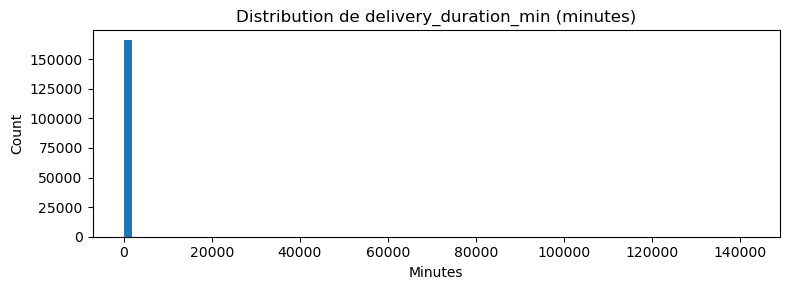

Percentiles:
{0.01: 19.233333333333334, 0.05: 24.9, 0.25: 35.15, 0.5: 44.416666666666664, 0.75: 56.43333333333333, 0.95: 81.28333333333333, 0.99: 108.25950000000012}


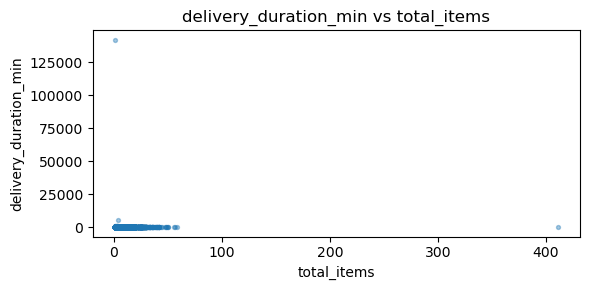

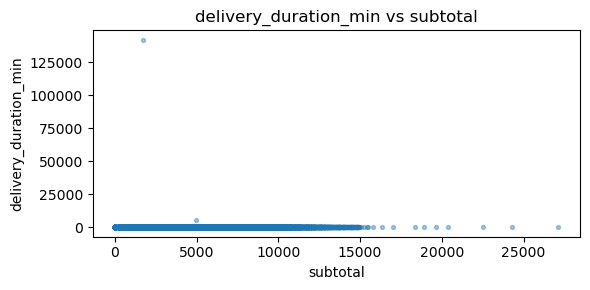

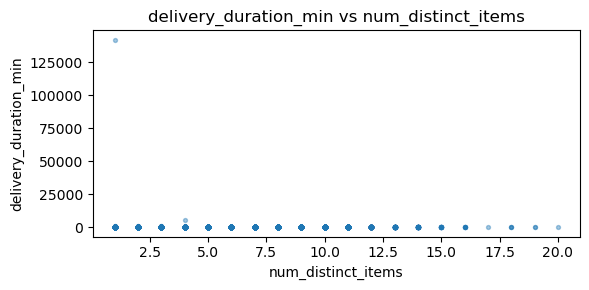

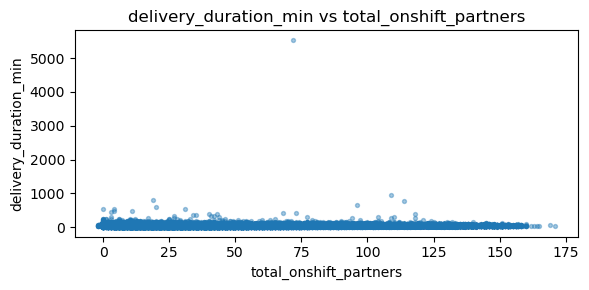

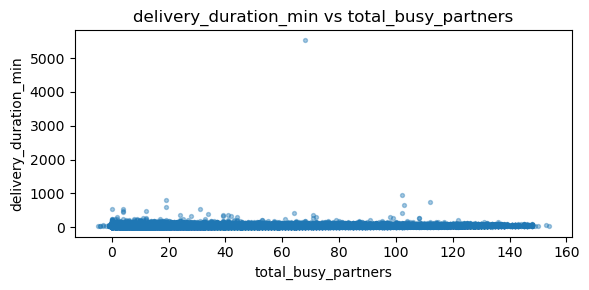

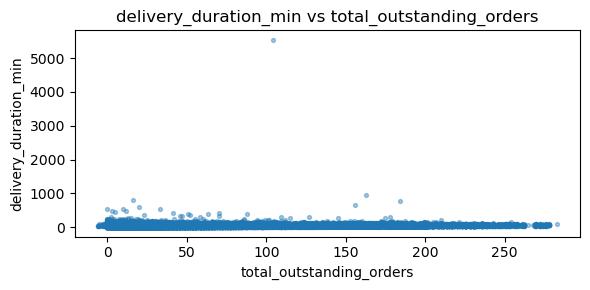

In [8]:

# 8) Visualisations rapides
import matplotlib.pyplot as plt

# Histogramme cible
if 'delivery_duration_min' in df.columns:
    data = df['delivery_duration_min'].dropna()
    plt.figure(figsize=(8,3))
    plt.hist(data, bins=80)
    plt.title('Distribution de delivery_duration_min (minutes)')
    plt.xlabel('Minutes'); plt.ylabel('Count'); plt.tight_layout()
    plt.show()
    print('Percentiles:')
    print(data.quantile([0.01,0.05,0.25,0.5,0.75,0.95,0.99]).to_dict())

# Scatter target vs features
features_to_plot = [c for c in ['total_items','subtotal','num_distinct_items','total_onshift_partners','total_busy_partners','total_outstanding_orders'] if c in df.columns]
if 'delivery_duration_min' in df.columns and len(features_to_plot):
    for c in features_to_plot:
        plt.figure(figsize=(6,3))
        plt.scatter(df[c], df['delivery_duration_min'], s=8, alpha=0.4)
        plt.title(f'delivery_duration_min vs {c}')
        plt.xlabel(c); plt.ylabel('delivery_duration_min')
        plt.tight_layout(); plt.show()


In [9]:

# 9) Matrice de corrélation (numérique)
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    corr = num_df.corr().round(3)
    display(corr)
    if 'delivery_duration_min' in corr.columns:
        print('\nCorrélations avec la cible (delivery_duration_min):')
        print(corr['delivery_duration_min'].sort_values(ascending=False))
else:
    print('Pas assez de colonnes numériques pour corrélations.')


,market_id,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_duration_min
market_id,1.000,-0.002,-0.012,0.009,-0.003,-0.003,0.069,0.060,0.062,-0.006
total_items,-0.002,1.000,0.556,0.760,-0.390,-0.056,0.033,0.030,0.036,0.004
subtotal,-0.012,0.556,1.000,0.679,0.040,0.511,0.132,0.128,0.132,0.010
num_distinct_items,0.009,0.760,0.679,1.000,-0.448,0.043,0.068,0.064,0.071,0.006
min_item_price,-0.003,-0.390,0.040,-0.448,1.000,0.545,0.039,0.041,0.037,0.005
max_item_price,-0.003,-0.056,0.511,0.043,0.545,1.000,0.130,0.129,0.128,0.009
total_onshift_partners,0.069,0.033,0.132,0.068,0.039,0.130,1.000,0.944,0.936,0.060
total_busy_partners,0.060,0.030,0.128,0.064,0.041,0.129,0.944,1.000,0.933,0.076
total_outstanding_orders,0.062,0.036,0.132,0.071,0.037,0.128,0.936,0.933,1.000,0.146
delivery_duration_min,-0.006,0.004,0.010,0.006,0.005,0.009,0.060,0.076,0.146,1.000



Corrélations avec la cible (delivery_duration_min):
delivery_duration_min       1.000
total_outstanding_orders    0.146
total_busy_partners         0.076
total_onshift_partners      0.060
subtotal                    0.010
max_item_price              0.009
num_distinct_items          0.006
min_item_price              0.005
total_items                 0.004
market_id                  -0.006
Name: delivery_duration_min, dtype: float64


In [10]:

# 10) Top valeurs pour colonnes catégoriques
cat_cols = [c for c in df.columns if df[c].dtype == object or df[c].dtype.name == 'category']
for c in cat_cols:
    print(f"\nColonne: {c} (top 10 valeurs)")
    display(df[c].fillna('NaN').astype(str).value_counts().head(10))



Colonne: store_id (top 10 valeurs)


store_id
                                    3452
d43ab110ab2489d6b9b2caa394bf920f     918
757b505cfd34c64c85ca5b5690ee5293     839
faacbcd5bf1d018912c116bf2783e9a1     802
45c48cce2e2d7fbdea1afc51c7c6ad26     704
c9f0f895fb98ab9159f51fd0297e236d     584
dc5689792e08eb2e219dce49e64c885b     542
fbd7939d674997cdb4692d34de8633c4     527
f7177163c833dff4b38fc8d2872f1ec6     524
f15d337c70078947cfe1b5d6f0ed3f13     520
Name: count, dtype: int64


Colonne: store_primary_category (top 10 valeurs)


store_primary_category
american    16736
pizza       14916
mexican     14005
burger       9909
japanese     8242
sandwich     8213
chinese      8038
             7572
dessert      7182
italian      6424
Name: count, dtype: int64


Colonne: order_protocol (top 10 valeurs)


order_protocol
1.0    47283
3.0    46456
5.0    35922
2.0    21381
4.0    16952
        4310
6.0      618
7.0       19
Name: count, dtype: int64

In [11]:

# 11) Feature engineering exemple (ne modifie pas les originaux sans vérif.)
if 'created_at' in df.columns:
    df['hour'] = df['created_at'].dt.hour
    df['weekday'] = df['created_at'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    df['is_peak'] = df['hour'].isin([11,12,13,18,19,20]).astype(int)

if 'total_busy_partners' in df.columns and 'total_onshift_partners' in df.columns:
    df['load_ratio'] = df['total_busy_partners'] / (df['total_onshift_partners'] + 1)

if 'total_items' in df.columns and 'num_distinct_items' in df.columns:
    df['items_per_distinct'] = df['total_items'] / (df['num_distinct_items'] + 1)

display(df[[c for c in ['hour','weekday','is_weekend','is_peak','load_ratio','items_per_distinct'] if c in df.columns]].head(8))


,hour,weekday,is_weekend,is_peak,load_ratio,items_per_distinct
0,22.0,4.0,0,0,NaN,0.800000
1,21.0,1.0,0,0,1.000000,0.500000
2,20.0,3.0,0,1,0.000000,0.500000
3,21.0,1.0,0,0,0.500000,1.000000
4,2.0,6.0,1,0,0.857143,0.750000
5,20.0,2.0,0,1,0.666667,0.750000
6,2.0,5.0,1,0,0.818182,0.666667
7,3.0,3.0,0,0,1.000000,0.800000


In [12]:

# 12) Recommandations et exemples d'imputation
print('Colonnes avec >30% de NA (à investiguer) :')
missing_summary = df.isna().mean().round(3) * 100
display(missing_summary[missing_summary > 30])

# Exemple d'imputation simple (décommente pour appliquer)
# numeric_cols_present = [c for c in numeric_cols if c in df.columns]
# for c in numeric_cols_present:
#     df[c].fillna(df[c].median(), inplace=True)
# for c in cat_cols:
#     df[c].fillna('unknown', inplace=True)


Colonnes avec >30% de NA (à investiguer) :


Series([], dtype: float64)

In [13]:

# 13) Sauvegarder un fichier nettoyé et un aperçu
out_clean = 'datadelevry_clean_full.csv'
preview = 'datadelevry_clean_preview.csv'
df.to_csv(out_clean, index=False)
df.head(2000).to_csv(preview, index=False)
print('Fichiers sauvegardés :', out_clean, 'et', preview)


Fichiers sauvegardés : datadelevry_clean_full.csv et datadelevry_clean_preview.csv



# 14) Étapes suivantes recommandées
# - Data Preparation (imputation, encodage, scaling)
# - BO1: pipeline supervisé (split temporel, baseline LGBM, tuning)
# - BO2: clustering (StandardScaler + KMeans/DBSCAN)
# - BO3: PCA/UMAP pour réduction et visualisation

print('Notebook Data Understanding prêt. Passe à Data Preparation quand tu veux.')


In [14]:
# 15) Détection des doublons
nb_total = len(df)
nb_duplicated = df.duplicated().sum()
print(f"Nombre de doublons (lignes identiques) : {nb_duplicated} sur {nb_total} lignes ({100*nb_duplicated/nb_total:.2f}%)")
if nb_duplicated > 0:
    display(df[df.duplicated()].head())



Nombre de doublons (lignes identiques) : 105 sur 172941 lignes (0.06%)


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_duration_min,hour,weekday,is_weekend,is_peak,load_ratio,items_per_distinct
172836,1.0,2015-01-30 05:23:32,2015-01-30 06:00:17,86df7dcfd896fcaf2674f757a2463eba,breakfast,3.0,2.0,1145.0,2.0,250.0,...,13.0,16.0,19.0,36.750000,5.0,4.0,0,0,1.142857,0.666667
172837,NaN,2015-01-24 01:48:01,2015-01-24 02:21:37,320722549d1751cf3f247855f937b982,steak,2.0,1.0,895.0,1.0,895.0,...,88.0,82.0,NaN,33.600000,1.0,5.0,1,0,0.921348,0.500000
172838,2.0,2015-02-01 02:11:02,2015-02-01 03:06:31,37c9bc66ebd3a2e455ee2a74feae4c0e,japanese,5.0,2.0,1940.0,2.0,945.0,...,105.0,NaN,165.0,55.483333,2.0,6.0,1,0,NaN,0.666667
172839,4.0,2015-02-08 03:14:37,2015-02-08 04:04:13,8f14e45fceea167a5a36dedd4bea2543,mediterranean,3.0,NaN,5140.0,4.0,600.0,...,118.0,115.0,201.0,49.600000,3.0,6.0,1,0,0.966387,NaN
172840,1.0,2015-02-08 03:25:03,2015-02-08 04:23:13,c0a62e133894cdce435bcb4a5df1db2d,japanese,3.0,7.0,4590.0,5.0,495.0,...,54.0,56.0,89.0,58.166667,3.0,6.0,1,0,1.018182,1.166667


In [15]:
# 16) Data Preparation — Décisions et application

# 1. Suppression des doublons
df = df.drop_duplicates()
print(f"Après suppression des doublons : {df.shape}")

# 2. Gestion des valeurs manquantes
# Imputation simple pour les colonnes numériques
numeric_cols_present = [c for c in ['market_id', 'total_items', 'subtotal', 'num_distinct_items',
                                    'min_item_price', 'max_item_price', 'total_onshift_partners',
                                    'total_busy_partners', 'total_outstanding_orders'] if c in df.columns]
for c in numeric_cols_present:
    df[c].fillna(df[c].median(), inplace=True)

# Imputation simple pour les colonnes catégorielles
cat_cols = [c for c in df.columns if df[c].dtype == object or df[c].dtype.name == 'category']
for c in cat_cols:
    df[c].fillna('unknown', inplace=True)

# 3. Nettoyage des outliers sur la cible
if 'delivery_duration_min' in df.columns:
    # On garde uniquement les valeurs entre 0 et 24h (1440 min)
    df = df[(df['delivery_duration_min'] >= 0) & (df['delivery_duration_min'] <= 1440)]
    print(f"Après nettoyage des outliers sur la cible : {df.shape}")

# 4. Encodage des variables catégorielles (exemple : one-hot encoding)
cat_to_encode = [c for c in cat_cols if df[c].nunique() < 20 and c != 'unknown']
if cat_to_encode:
    df = pd.get_dummies(df, columns=cat_to_encode, prefix=cat_to_encode)

# 5. Mise à l’échelle (scaling) — exemple avec StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
if numeric_cols_present:
    df[numeric_cols_present] = scaler.fit_transform(df[numeric_cols_present])

# 6. Suppression des colonnes inutiles (exemple : identifiants uniques)
id_cols = [c for c in df.columns if 'id' in c.lower() and c not in ['market_id']]
if id_cols:
    df.drop(columns=id_cols, inplace=True)
    print(f"Colonnes identifiants supprimées : {id_cols}")

print('Data Preparation terminée. Shape finale :', df.shape)
display(df.head())



Après suppression des doublons : (172836, 21)
Après nettoyage des outliers sur la cible : (166042, 21)


C:\Users\chams\AppData\Local\Temp\ipykernel_17432\186580798.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
C:\Users\chams\AppData\Local\Temp\ipykernel_17432\186580798.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

Colonnes identifiants supprimées : ['store_id']
Data Preparation terminée. Shape finale : (166042, 27)


,market_id,created_at,actual_delivery_time,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,...,load_ratio,items_per_distinct,order_protocol_,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,-1.315588,2015-02-06 22:24:17,2015-02-06 23:27:16,american,0.302179,0.423178,0.822070,-0.244021,0.145657,-0.213267,...,NaN,0.80,False,True,False,False,False,False,False,False
1,-0.651866,2015-02-10 21:49:25,2015-02-10 22:56:29,mexican,-0.828105,-0.429073,-1.026480,1.390272,0.435691,-1.310369,...,1.000000,0.50,False,False,True,False,False,False,False,False
2,0.011856,2015-01-22 20:39:28,2015-01-22 21:09:09,,-0.828105,-0.429073,-1.026480,2.359603,1.336418,-1.310369,...,0.000000,0.50,False,True,False,False,False,False,False,False
3,0.011856,2015-02-03 21:21:45,2015-02-03 22:13:00,,1.055702,2.336181,1.438254,-0.160658,1.156273,-1.310369,...,0.500000,1.00,False,True,False,False,False,False,False,False
4,0.011856,2015-02-15 02:40:36,2015-02-15 03:20:26,,-0.074582,0.677029,0.205887,-0.170352,0.795982,-1.157993,...,0.857143,0.75,False,True,False,False,False,False,False,False


In [16]:
# Vérification des valeurs manquantes dans 'store_primary_category'
if 'store_primary_category' in df.columns:
    n_total = len(df)
    n_na = df['store_primary_category'].isna().sum()
    print(f"Valeurs manquantes dans 'store_primary_category' : {n_na} sur {n_total} lignes ({100*n_na/n_total:.2f}%)")
    print("Top 10 valeurs (y compris les manquantes imputées) :")
    display(df['store_primary_category'].value_counts(dropna=False).head(10))
else:
    print("Colonne 'store_primary_category' absente du DataFrame.")



Valeurs manquantes dans 'store_primary_category' : 0 sur 166042 lignes (0.00%)
Top 10 valeurs (y compris les manquantes imputées) :


store_primary_category
american    16058
pizza       14302
mexican     13455
burger       9496
japanese     7919
sandwich     7891
chinese      7710
             7283
dessert      6910
italian      6148
Name: count, dtype: int64

Valeurs manquantes avant : 0, après imputation : 0
Mode utilisé pour l'imputation : american
store_primary_category
american    23341
pizza       14302
mexican     13455
burger       9496
japanese     7919
sandwich     7891
chinese      7710
dessert      6910
italian      6148
fast         6144
Name: count, dtype: int64
